## Installing Dependencies

In [ ]:
#for emoji detection
!pip install emot
!pip install emoji==1.7.0

# Topic Modelling
!pip install pyLDAvis
!pip install langdetect

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import TextBlob
import string
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
from pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import spacy
import itertools
import collections
from nltk import bigrams

from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

import seaborn as sns

import emoji
from emot.emo_unicode import UNICODE_EMOJI

import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.options.display.max_colwidth = None

## Data Split

In [ ]:
df_processed = pd.read_csv("../Data/Final Data.csv")

In [ ]:
df_processed.head()

,Unnamed: 0,Unnamed: 0.1,text,class,cleaned_string,processed,processed_str
0,0,10894,might fuck around and go to sleep at 2 am instead of 4 prob not actually but it would be good for me,non-suicide,might fuck around and go to sleep at am instead of prob not actually but it would be good for me,"['might', 'fuck', 'around', 'go', 'sleep', 'instead', 'probe', 'actually', 'would', 'good']",might fuck around go sleep instead probe actually would good
1,1,10895,The Hasburgs got that jawline doe. They just obtained it in... questionable ways.,non-suicide,The Hasburgs got that jawline doe They just obtained it in questionable ways,"['hamburg', 'get', 'saline', 'doe', 'obtain', 'questionable', 'way']",hamburg get saline doe obtain questionable way
2,2,10896,i miss 2019 when everything seemed like it was just fine,non-suicide,i miss when everything seemed like it was just fine,"['miss', 'everything', 'seem', 'like', 'fine']",miss everything seem like fine
3,3,10897,I'm tired of being conscious So I'll go get unconscious for eight hours straight,non-suicide,Im tired of being conscious So Ill go get unconscious for eight hours straight,"['tire', 'conscious', 'ill', 'go', 'get', 'unconscious', 'eight', 'hour', 'straight']",tire conscious ill go get unconscious eight hour straight
4,4,10898,"I’m tiredThis is it, one last cherry on top, one last failure.\nI’m tired, and I cannot do this anymore. I’ve failed every single dream and goal I have set and I’ve worked so hard and given so much of my life for those goals. I worked so hard, for nothing and I can’t do this anymore. This life fucking sucks and I’m sorry for the rest of y’all that will have to suffer for however much longer y’all are here. I’m a disappointment alive or not, to my self and everyone around me, but life goes on, good bye",suicide,I’m tiredThis is it one last cherry on top one last failure I’m tired and I cannot do this anymore I’ve failed every single dream and goal I have set and I’ve worked so hard and given so much of my life for those goals I worked so hard for nothing and I can’t do this anymore This life fucking sucks and I’m sorry for the rest of y’all that will have to suffer for however much longer y’all are here I’m a disappointment alive or not to my self and everyone around me but life goes on good bye,"['i’m', 'tiredthis', 'one', 'last', 'cherry', 'top', 'one', 'last', 'failure', 'i’m', 'tire', 'cannot', 'anymore', 'i’ve', 'fail', 'every', 'single', 'dream', 'goal', 'set', 'i’ve', 'work', 'hard', 'give', 'much', 'life', 'goal', 'work', 'hard', 'nothing', 'can’t', 'anymore', 'life', 'fuck', 'suck', 'i’m', 'sorry', 'rest', 'y’all', 'suffer', 'however', 'much', 'longer', 'y’all', 'i’m', 'disappointment', 'alive', 'self', 'everyone', 'around', 'life', 'go', 'good', 'bye']",i’m tiredthis one last cherry top one last failure i’m tire cannot anymore i’ve fail every single dream goal set i’ve work hard give much life goal work hard nothing can’t anymore life fuck suck i’m sorry rest y’all suffer however much longer y’all i’m disappointment alive self everyone around life go good bye


In [ ]:
print(len(df_processed))
df_processed[['class', 'processed']].groupby('class').count()

137810


,processed
class,
non-suicide,83718
suicide,54092


In [ ]:
#change target variable label to 1 = suicide, 0 = non suicide 
df_processed.reset_index(drop=True, inplace=True)
df_processed.replace({"class": {"suicide": 1, "non-suicide": 0}}, inplace=True)
df_processed.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'text'], inplace=True)
df_processed

,class,cleaned_string,processed,processed_str
0,0,might fuck around and go to sleep at am instead of prob not actually but it would be good for me,"['might', 'fuck', 'around', 'go', 'sleep', 'instead', 'probe', 'actually', 'would', 'good']",might fuck around go sleep instead probe actually would good
1,0,The Hasburgs got that jawline doe They just obtained it in questionable ways,"['hamburg', 'get', 'saline', 'doe', 'obtain', 'questionable', 'way']",hamburg get saline doe obtain questionable way
2,0,i miss when everything seemed like it was just fine,"['miss', 'everything', 'seem', 'like', 'fine']",miss everything seem like fine
3,0,Im tired of being conscious So Ill go get unconscious for eight hours straight,"['tire', 'conscious', 'ill', 'go', 'get', 'unconscious', 'eight', 'hour', 'straight']",tire conscious ill go get unconscious eight hour straight
4,1,I’m tiredThis is it one last cherry on top one last failure I’m tired and I cannot do this anymore I’ve failed every single dream and goal I have set and I’ve worked so hard and given so much of my life for those goals I worked so hard for nothing and I can’t do this anymore This life fucking sucks and I’m sorry for the rest of y’all that will have to suffer for however much longer y’all are here I’m a disappointment alive or not to my self and everyone around me but life goes on good bye,"['i’m', 'tiredthis', 'one', 'last', 'cherry', 'top', 'one', 'last', 'failure', 'i’m', 'tire', 'cannot', 'anymore', 'i’ve', 'fail', 'every', 'single', 'dream', 'goal', 'set', 'i’ve', 'work', 'hard', 'give', 'much', 'life', 'goal', 'work', 'hard', 'nothing', 'can’t', 'anymore', 'life', 'fuck', 'suck', 'i’m', 'sorry', 'rest', 'y’all', 'suffer', 'however', 'much', 'longer', 'y’all', 'i’m', 'disappointment', 'alive', 'self', 'everyone', 'around', 'life', 'go', 'good', 'bye']",i’m tiredthis one last cherry top one last failure i’m tire cannot anymore i’ve fail every single dream goal set i’ve work hard give much life goal work hard nothing can’t anymore life fuck suck i’m sorry rest y’all suffer however much longer y’all i’m disappointment alive self everyone around life go good bye
...,...,...,...,...
137805,0,I did something today I went sledding with my friends It may not seem like much but for me ot is a pretty big milestone after all that i am going through I am proud of myself,"['something', 'today', 'go', 'shed', 'friend', 'may', 'seem', 'like', 'much', 'pretty', 'big', 'limestone', 'go', 'proud']",something today go shed friend may seem like much pretty big limestone go proud
137806,0,If you dont like rock then your not going to get anything on this but here I go httpsmusictastespacematchlavishwalrusvisionaryeggsr,"['dont', 'like', 'rock', 'go', 'get', 'anything', 'go', 'httpsmusictastespacematchlavishwalrusvisionaryeggsr']",dont like rock go get anything go httpsmusictastespacematchlavishwalrusvisionaryeggsr
137807,0,You how you can tell i have so many friends and is not lonely and everything deprived I prebought little nightmares and I count the days till it comes out,"['tell', 'many', 'friend', 'lonely', 'everything', 'deprive', 'prebought', 'little', 'nightmare', 'count', 'day', 'till', 'come']",tell many friend lonely everything deprive prebought little nightmare count day till come
137808,0,pee probably tastes like salty tea smirking_face sweat_droplets double_exclamation_mark can someone who drank pee before confirm this face_with_rolling_eyes double_exclamation_mark,"['see', 'probably', 'taste', 'like', 'salt', 'tea', 'smirking_face', 'sweat_droplets', 'double_exclamation_mark', 'someone', 'drank', 'see', 'confirm', 'face_with_rolling_eyes', 'double_exclamation_mark']",see probably taste like salt tea smirking_face sweat_droplets double_exclamation_mark someone drank see confirm face_with_rolling_eyes double_exclamation_mark


In [ ]:
#https://datascience.stackexchange.com/questions/80770/i-do-feature-engineering-on-the-full-dataset-is-this-wrong#:~:text=You're%20correct%3A%20you%20should,into%20the%20training%20data%20set.
X_train, X_test, Y_train, Y_test = train_test_split(df_processed[['cleaned_string', 'processed_str']], df_processed['class'], random_state= 4222, test_size=0.2, stratify= df_processed['class'])

In [ ]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(110248, 2) (27562, 2)
(110248,) (27562,)


## Feature Engineering

### Functions Required

In [ ]:
# Reference: https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d
# Textblob Sentiment Analysis: [-1, 1] : [negative sentiments, positive sentiments]
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

# Length of text
def lenText(text):
  return len(text)

# Num of words
def numWords(text):
  return len(text.split())

# Num of unique words
def numUniqueWords(text):
  unique_words = set(text.split())
  return len(unique_words)

# Average number of adjectives and adverbs generated via POS tagging using the NLTK package
def get_part_of_speech_tags(token):
    
    """Maps POS tags to first character of the pos tagging returned by pos_tag.
    We are focussing on Verbs, Nouns, Adjectives and Adverbs; otherwise return NOUN"""

    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    tag = nltk.pos_tag([token])[0][1][0].upper()
    
    return tag_dict.get(tag, wordnet.NOUN)

def count_pos(sentence):
  adj = sentence.count('a')
  noun = sentence.count('n')
  verb = sentence.count('v')
  adv = sentence.count('r')
  return adj, noun, verb, adv

# CountVectorizer
def get_cv_matrix(df):
  cv_vectorizer = CountVectorizer(max_df=0.9, max_features=5000, stop_words='english')
  bow_matrix = cv_vectorizer.fit_transform(df['processed_str'].values.astype('U'))
  cv_feature_names = cv_vectorizer.get_feature_names_out()
  cv_matrix = pd.DataFrame(bow_matrix.toarray(), columns=list(cv_feature_names))
  return cv_vectorizer, bow_matrix, cv_matrix, cv_feature_names

# Tf-idf
def get_tfidf(df):
  tfidf_vectorizer = TfidfVectorizer(max_df=0.90, max_features=5000, stop_words="english")
  tfidf = tfidf_vectorizer.fit_transform(df['processed_str'])
  tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
  return tfidf, tfidf_feature_names

# Named Entity Recognition
nlp = spacy.load('en_core_web_sm')
def get_ner(sentence):
  doc = nlp(sentence)
  ents = [(e.text, e.label_) for e in doc.ents]
  return ents

def count_topic(arr, topic):
  count = 0
  for text, label in arr:
    if label == topic:
      count = count + 1
  return count

all_topics = ["PERSON", "NORP", "FAC", "ORG", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW", 
              "LANGUAGE", "DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]
for i in all_topics:
  print(i + " - " + spacy.explain(i))

def get_relevant_topics(all_topics, train_df):
  temp_df = pd.DataFrame()
  ner = train_df["processed_str"].apply(lambda x: get_ner(x))
  for topic in all_topics:
    temp_df[topic] = ner.apply(lambda x: count_topic(x, topic)) 
  non_zero_rows = np.count_nonzero(temp_df, axis=0)
  relevant_topics_indices = np.where(non_zero_rows > 0.1 * df_processed.shape[0])[0]
  relevant_topics = []
  for i in relevant_topics_indices:
    relevant_topics.append(all_topics[i])
  
  return temp_df, relevant_topics


PERSON - People, including fictional
NORP - Nationalities or religious or political groups
FAC - Buildings, airports, highways, bridges, etc.
ORG - Companies, agencies, institutions, etc.
LOC - Non-GPE locations, mountain ranges, bodies of water
PRODUCT - Objects, vehicles, foods, etc. (not services)
EVENT - Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART - Titles of books, songs, etc.
LAW - Named documents made into laws.
LANGUAGE - Any named language
DATE - Absolute or relative dates or periods
TIME - Times smaller than a day
PERCENT - Percentage, including "%"
MONEY - Monetary values, including unit
QUANTITY - Measurements, as of weight or distance
ORDINAL - "first", "second", etc.
CARDINAL - Numerals that do not fall under another type


### EDA on train set

In [ ]:
train = pd.concat([X_train, Y_train], axis=1)

class
0    0.041023
1   -0.020946
Name: polarity, dtype: float64

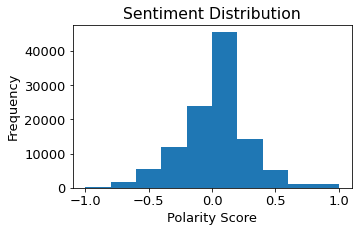

In [ ]:
# Sentiment Distribution: -1 indicates negative, 1 indicates positive
train['polarity'] = train['processed_str'].apply(lambda x: get_polarity(x))
plt.figure(figsize=(5,3))
polarity_graph = train['polarity'].plot(kind='hist', title = "Sentiment Distribution", )
polarity_graph.set_xlabel("Polarity Score")

train.groupby('class')['polarity'].mean()

Number of characters
class
0    214.004823
1    366.159842
Name: char_count, dtype: float64

Number of words
class
0    40.193926
1    72.650460
Name: word_count, dtype: float64

Number of unique words
class
0    31.295652
1    52.731132
Name: unique_word_count, dtype: float64


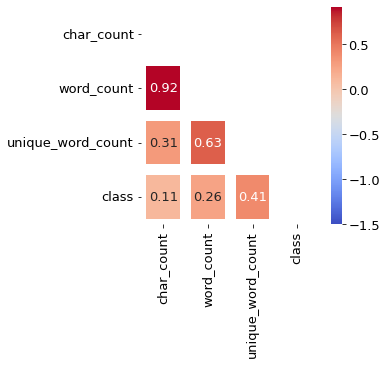

In [ ]:
# Length of sentence/ Num of words
print("Number of characters")
train['char_count'] = train['cleaned_string'].apply(lenText)
print(train.groupby('class')['char_count'].mean())

print("\nNumber of words")
train['word_count'] = train['cleaned_string'].apply(numWords)
print(train.groupby('class')['word_count'].mean())

print("\nNumber of unique words")
train['unique_word_count'] = train['cleaned_string'].apply(numUniqueWords)
print(train.groupby('class')['unique_word_count'].mean())

# Heat map to see if length has effect on class/ sentiment
correlation = train[['char_count', 'word_count', 'unique_word_count', 'class']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4,4))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 13}, linewidths=10, vmin=-1.5, mask=mask);

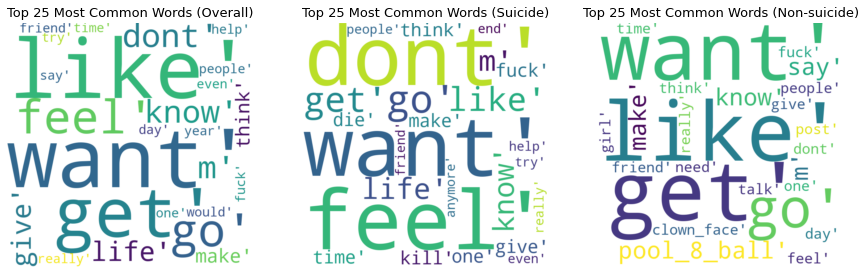

In [ ]:
# Word Cloud
def get_all_words(df):
  all_words = []

  for row in df["processed_str"].apply(lambda x: x.split(' ')):
    all_words += row
  
  return all_words

def plot_word_cloud(df, axis_idx):
  most_common_words = FreqDist(get_all_words(df)).most_common(25)       
  wordcloud = WordCloud(width=800, height=800, background_color='white').generate(str(most_common_words))
  axis[axis_idx].imshow(wordcloud, interpolation="bilinear")
  axis[axis_idx].axis('off')

# plot the WordCloud image
rcParams['figure.figsize'] = 15, 15
figure, axis = plt.subplots(1, 3)

# Overall  
plot_word_cloud(train, 0)
axis[0].set_title('Top 25 Most Common Words (Overall)', fontsize=13)

# Suicide
plot_word_cloud(train[train["class"] == 1], 1)
axis[1].set_title('Top 25 Most Common Words (Suicide)', fontsize=13)
 
# Non-suicide
plot_word_cloud(train[train["class"] == 0], 2)
axis[2].set_title('Top 25 Most Common Words (Non-suicide)', fontsize=13)

plt.show()

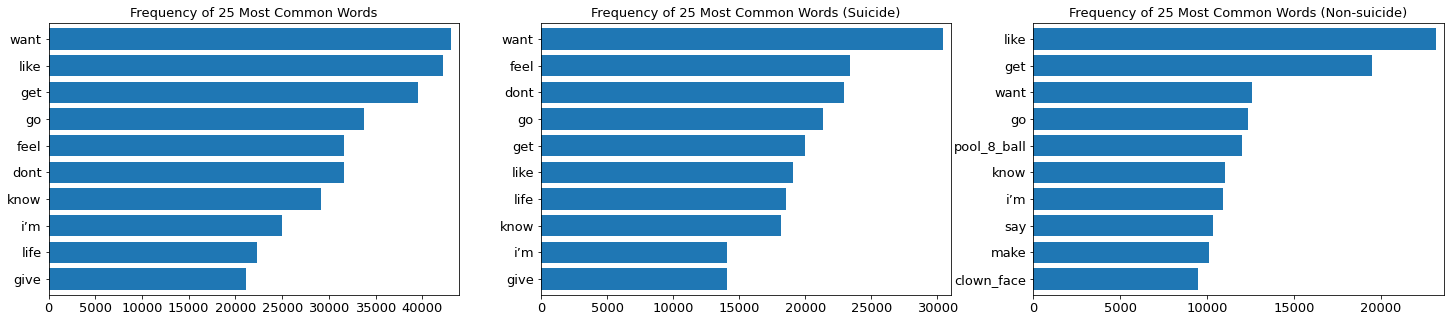

In [ ]:
# Word Frequency
def plot_top_10(df, axis_idx):
  most_common_10 = FreqDist(get_all_words(df)).most_common(10)
  x, y = zip(*most_common_10)
  axis[axis_idx].margins(0.02)
  axis[axis_idx].barh(x, y)
  # axis[axis_idx].set_xlabel('Words', fontsize=13)
  # axis[axis_idx].set_ylabel('Frequency of Words', fontsize=13)
  axis[axis_idx].invert_yaxis()

plt.rcParams.update({'font.size': 13})
rcParams['figure.figsize'] = 25, 5
figure, axis = plt.subplots(1, 3)

# Frequency of top 25 words (Overall)
plot_top_10(train, 0)
axis[0].set_title('Frequency of 25 Most Common Words', fontsize=13)

# Frequency of top 25 words (Suicide)
plot_top_10(train[train["class"] == 1], 1)
axis[1].set_title('Frequency of 25 Most Common Words (Suicide)', fontsize=13)
 
# Frequency of top 25 words (non-Suicide)
plot_top_10(train[train["class"] == 0], 2)
axis[2].set_title('Frequency of 25 Most Common Words (Non-suicide)', fontsize=13)

plt.show()

Text(0.5, 1.0, 'Frequency of 10 Most Common Bigrams (Non-suicide)')

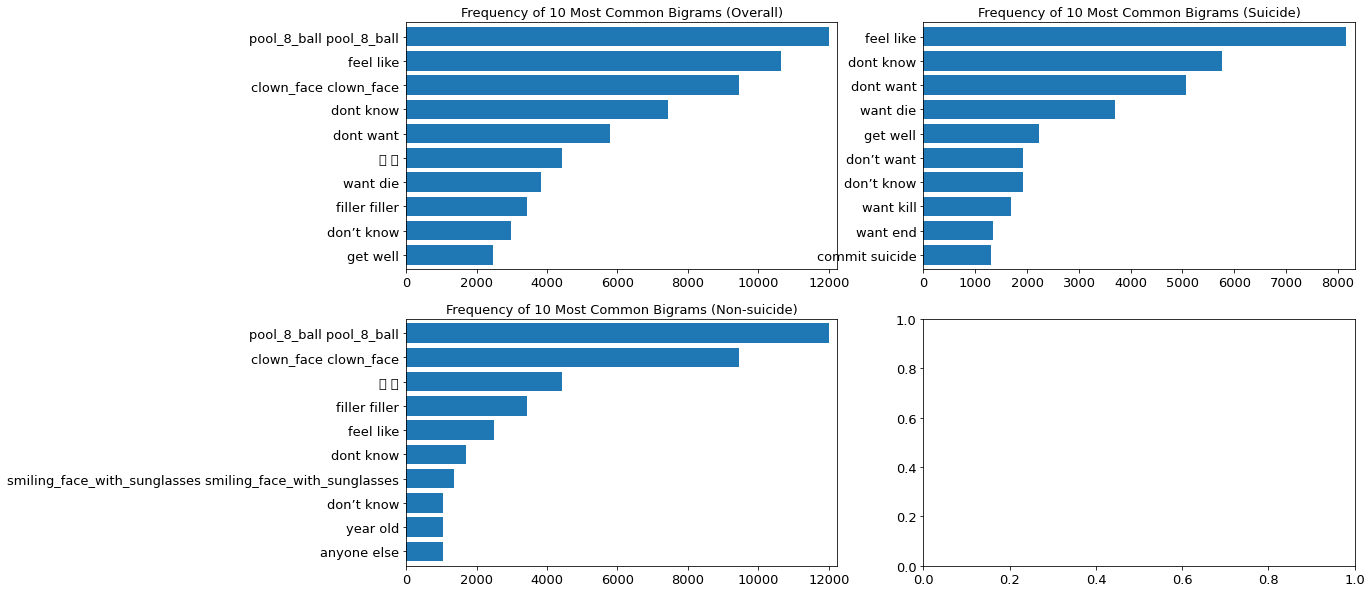

In [ ]:
# N-gram
def plot_bigrams(df, axis_idx):
  sentences = [text.split() for text in df['processed_str']]
  terms_bigram = [list(bigrams(text)) for text in sentences]
  bigrams_list = list(itertools.chain(*terms_bigram))
  bigram_counts = collections.Counter(bigrams_list)
  bigram_df = pd.DataFrame(bigram_counts.most_common(10),
                             columns=['Bigram', 'Count'])
  
  bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: x[0] + ' ' + x[1])

  axis[axis_idx].margins(0.02)
  axis[axis_idx].barh(bigram_df['Bigram'], bigram_df['Count'])
  # axis[axis_idx].set_xlabel('Bigrams')
  # axis[axis_idx].set_ylabel('Frequency of Bigrams')
  axis[axis_idx].invert_yaxis()

rcParams['figure.figsize'] = 17, 10
figure, axis = plt.subplots(2, 2)

from nltk import bigrams
# Overall
plot_bigrams(train, (0,0))
axis[0,0].set_title('Frequency of 10 Most Common Bigrams (Overall)', fontsize=13)

# Suicide
plot_bigrams(train[train['class'] == 1], (0,1))
axis[0,1].set_title('Frequency of 10 Most Common Bigrams (Suicide)', fontsize=13)

# Non-suicide
plot_bigrams(train[train['class'] == 0], (1,0))
axis[1,0].set_title('Frequency of 10 Most Common Bigrams (Non-suicide)', fontsize=13)

In [ ]:
# Topic Modelling Non-Negative Matrix Factorization (NMF)
# 1. TF-IDF
def get_tfidf(df):
  tfidf_vectorizer = TfidfVectorizer(max_df=0.90, max_features=5000, stop_words="english")
  tfidf = tfidf_vectorizer.fit_transform(df['processed_str'])
  tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
  return tfidf, tfidf_feature_names

# 2. NMF
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

def display_nmf(tfidf, feature_names):
  nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
  display_topics(nmf, feature_names, 10)

In [ ]:
# 3. Topic Distribution (Overall)
tfidf, tfidf_feature_names = get_tfidf(train)
display_nmf(tfidf, tfidf_feature_names)

Topic 0:
want die don kill anymore live hurt pain end stop
Topic 1:
life think year time try end kill thing make suicide
Topic 2:
fuck shit hate god tire donna stupid life die kill
Topic 3:
feel like really bad don sad right shit felt suicidal
Topic 4:
talk anna bore chat friend really need pm play lonely
Topic 5:
dont know anymore care really live think ill people hurt
Topic 6:
filler text post bore award comment title anna flushed_face code
Topic 7:
help need try advice really tell gun suicidal suicide stop
Topic 8:
day post today good song hope birthday great school nice
Topic 9:
say girl people post like friend ask gun make look


In [ ]:
# 4. Topic Distribution (Suicide)
tfidf, tfidf_feature_names = get_tfidf(train[train["class"] == 1])
display_nmf(tfidf, tfidf_feature_names)

Topic 0:
think time try suicide day thought year make bad thing
Topic 1:
fuck shit hate god donna tire anna stupid die piece
Topic 2:
want die stop pain hurt end live scar sleep wish
Topic 3:
talk need really friend right toi pm somebody people message
Topic 4:
don ve know anymore ll care anna won doesn hurt
Topic 5:
feel like really bad make right way people suicidal felt
Topic 6:
dont know anymore care live really friend want think ill
Topic 7:
life end tire hate living live people point love wish
Topic 8:
help need try say ask post suicidal tell know friend
Topic 9:
kill way wish self reason anna say tell donna think


In [ ]:
# 5. Topic Distribution (Non-Suicide)
tfidf, tfidf_feature_names = get_tfidf(train[train["class"] == 0])
display_nmf(tfidf, tfidf_feature_names)

Topic 0:
know dont help need think people school really year time
Topic 1:
filler text title flushed_face code miller award file shit join
Topic 2:
talk bore anna chat pm discord hum hey number lonely
Topic 3:
post comment make award sub credit text parma image subreddit
Topic 4:
fuck shit hate god oh life donna holy stop suck
Topic 5:
like feel look shit really ink weird people kind don
Topic 6:
day today good song great hope nice happy birthday school
Topic 7:
say girl ask crush yes boy question gun cut guy
Topic 8:
want award dont don free love really comment hug tell
Topic 9:
friend play game make best discord new minecraft look server


### Adding new features

In [ ]:
# Create new features
def create_new_features(df):
  df['polarity'] = df['processed_str'].apply(lambda x: get_polarity(x))
  df['char_count'] = df['cleaned_string'].apply(lambda x: lenText(x))
  df['word_count'] = df['cleaned_string'].apply(lambda x: numWords(x))
  df['unique_word_count'] = df['cleaned_string'].apply(lambda x: numUniqueWords(x))

  df['tokens'] = df['processed_str'].apply(lambda x: x.split(' '))
  pos = pd.DataFrame(df['tokens'].apply(lambda x: [get_part_of_speech_tags(token) for token in x]))
  df['adj'] = pos["tokens"].apply(lambda x: x.count('a'))
  df['noun'] = pos["tokens"].apply(lambda x: x.count('n'))
  df['verb'] = pos["tokens"].apply(lambda x: x.count('v'))
  df['adv'] = pos["tokens"].apply(lambda x: x.count('r'))
 
  return df

In [ ]:
X_train_features = create_new_features(X_train)
X_train_features.drop(['cleaned_string', 'tokens'], axis=1, inplace=True)

X_test_features = create_new_features(X_test)
X_test_features.drop(['cleaned_string', 'tokens'], axis=1, inplace=True)

In [ ]:
temp_df, relevant_ner_topics = get_relevant_topics(all_topics, X_train_features)
for topic in relevant_ner_topics:
  X_train_features[topic.lower()] = temp_df[i]

ner = X_test_features["processed_str"].apply(lambda x: get_ner(x))
for topic in relevant_ner_topics:
  X_test_features[topic.lower()] = ner.apply(lambda x: count_topic(x, topic))

In [ ]:
print(X_train_features.shape, X_test_features.shape)
X_train_features.head()

In [ ]:
X_train_features.to_csv("../Data/X_train.csv")
X_test_features.to_csv("../Data/X_test.csv")
Y_train.to_csv("../Data/y_train.csv")
Y_test.to_csv("../Data/y_test.csv")